<div style="
  background-color:#0F172A;
  border-left:5px solid #3B82F6;
  padding:16px;
  border-radius:10px;
">

## Single-Vector vs. Multi-Vector RAG - Deep Dive

A hands-on guide to understanding **Dense Retrieval** vs. **Late Interaction (ColBERT)**.

**What you'll learn:**
- How Single Vectors struggle with **negation** and **synonyms**
- How Multi-Vectors preserve **token-level** meaning
- Visualizing the **Interaction Matrix** (The "Brain" of models like ColBERT)
- Calculating **MaxSim** scores manually

</div>

## Step 1: Install and Import Libraries

In [8]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Any
from sentence_transformers import SentenceTransformer

# Load a standard lightweight model for generating embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Create a Knowledge Base

We will use an **Insurance Policy** scenario. This is hard for AI because:
1.  It involves **Exclusions** (Negation).
2.  It uses **Synonyms** ("Water" vs "Liquid").
3.  It has **Distractors** (Same keywords, different context).

In [2]:
# Define a user query regarding a specific coverage type
query: str = "Does the policy cover water damage?"

# Define a list of documents representing the knowledge base
documents: list[str] = [
    # Hard Negative: Contains high keyword overlap ('water', 'damage') but explicitly negates coverage.
    "Flood and water damage are strictly EXCLUDED from coverage.",
    
    # True Positive: Semantically equivalent ('liquid spills') but lacks exact keywords.
    "We provide full protection against accidental liquid spills on electronics.",
    
    # Irrelevant Distractor: Contains 'water' but in an unrelated context.
    "Free water bottles are provided at the gym facility.",
    
    # Irrelevant Distractor: Contains 'damage' but refers to a different type.
    "Fire damage is covered up to $50,000."
]

print(f"🔎 Query: {query}")
print("-" * 40)
for i, doc in enumerate(documents):
    print(f"Doc {i}: {doc}")

🔎 Query: Does the policy cover water damage?
----------------------------------------
Doc 0: Flood and water damage are strictly EXCLUDED from coverage.
Doc 1: We provide full protection against accidental liquid spills on electronics.
Doc 2: Free water bottles are provided at the gym facility.
Doc 3: Fire damage is covered up to $50,000.


## Step 3: Strategy A - Single Vector (Bi-Encoder)

We compress the entire sentence into **one vector**. 
This often leads to "information loss", the model sees "water" and "damage" in Doc 0 and thinks it's a match, ignoring the word "EXCLUDED". Depending on the model, **Doc 0 (The Exclusion)** often ranks high because it shares the most words with the query. The Single Vector model struggles to "weigh" the word "EXCLUDED" heavily enough against the positive signal of "water damage".

In [3]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Calculates the Cosine Similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

print("🔢 Encoding documents into Single Vectors...")
# Sentence-transformers uses Mean Pooling by default to create one vector per document
query_vec: np.ndarray = model.encode(query)
doc_vecs: np.ndarray = model.encode(documents)

print(f"    Query Vector Shape: {query_vec.shape}")
print(f"    Doc Vector Shape:   {doc_vecs[0].shape}")

# Calculate similarity scores for each document
scores: list[float] = []
for i, doc_vec in enumerate(doc_vecs):
    score = cosine_sim(query_vec, doc_vec)
    scores.append(score)

# Display results sorted by score
df_single = pd.DataFrame({"Document": documents, "Cosine Score": scores})
df_single = df_single.sort_values("Cosine Score", ascending=False)

print("\n📊 SINGLE VECTOR RESULTS:")
display(df_single)

🔢 Encoding documents into Single Vectors...
    Query Vector Shape: (384,)
    Doc Vector Shape:   (384,)

📊 SINGLE VECTOR RESULTS:


,Document,Cosine Score
0,Flood and water damage are strictly EXCLUDED f...,0.552582
3,"Fire damage is covered up to $50,000.",0.422175
1,We provide full protection against accidental ...,0.376862
2,Free water bottles are provided at the gym fac...,0.231203


## Step 4: Strategy B - Multi-Vector (Late Interaction)

Instead of compressing, we extract vectors for **every single token**. 
This allows the model to, for example, compare "water" in the query against "liquid" in the document directly.

In [4]:
def get_token_embeddings(text: str) -> tuple[list[str], np.ndarray]:
    """Generates token-level embeddings for a given text string.
    
    Returns:
        tokens: A list of string tokens (including special tokens like [CLS]).
        embeddings: A numpy array of shape (seq_len, embedding_dim).
    """
    # 1. Tokenize and get IDs
    inputs = model.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    # 2. Get the actual string tokens.
    # We use `convert_ids_to_tokens` to ensure alignment with the model's view,
    # including special tokens like [CLS] (Start) and [SEP] (End).
    tokens = model.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # 3. Run Model to get Embeddings
    with torch.no_grad():
        outputs = model[0].auto_model(**inputs)
    
    # Get embeddings for all tokens. 
    # Output Shape: [1, seq_len, 384] -> converted to [seq_len, 384]
    embeddings = outputs.last_hidden_state[0].numpy() 
    return tokens, embeddings

# Inspect Doc 1 (The Liquid Spills doc) as an example
d1_text: str = documents[1]
tokens, vecs = get_token_embeddings(d1_text)

print(f"📄 Text: {d1_text}")
print(f"🔹 Tokens: {tokens}")
print(f"    Pm Vectors Shape: {vecs.shape} (One vector per token!)")

📄 Text: We provide full protection against accidental liquid spills on electronics.
🔹 Tokens: ['[CLS]', 'we', 'provide', 'full', 'protection', 'against', 'accidental', 'liquid', 'spill', '##s', 'on', 'electronics', '.', '[SEP]']
    Pm Vectors Shape: (14, 384) (One vector per token!)


## Step 5: The Interaction Matrix

We calculate the similarity of **Every Query Token** vs **Every Doc Token**.

🧮 Matrix Shape: (9, 14)


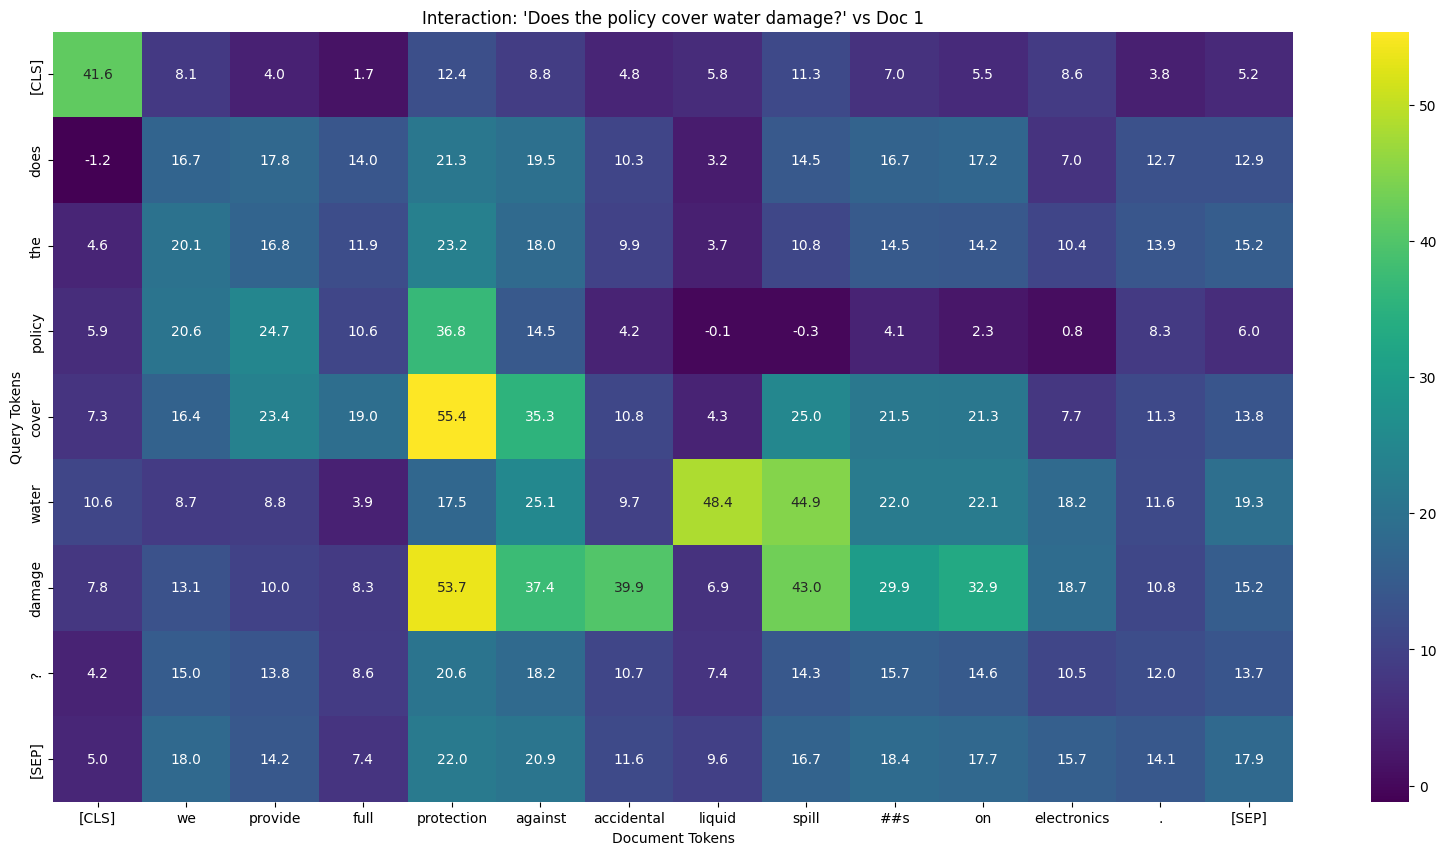

In [5]:
# 1. Get Query Tokens and Embeddings
q_tokens, q_vecs = get_token_embeddings(query)

# 2. Get Doc Tokens and Embeddings (Doc 1: Liquid Spills)
d_tokens, d_vecs = get_token_embeddings(documents[1]) 

# 3. Calculate Interaction (Dot Product)
# Resulting Matrix shape: (Query Tokens x Doc Tokens)
sim_matrix: np.ndarray = q_vecs @ d_vecs.T 

print(f"🧮 Matrix Shape: {sim_matrix.shape}")

# 4. Plot Heatmap to visualize token-to-token similarity
plt.figure(figsize=(20, 10))
sns.heatmap(sim_matrix, xticklabels=d_tokens, yticklabels=q_tokens, cmap="viridis", annot=True, fmt=".1f")
plt.title(f"Interaction: '{query}' vs Doc 1")
plt.xlabel("Document Tokens")
plt.ylabel("Query Tokens")
plt.show()

If we look at the matrix and find the row for **"water"** and the column for the **"liquid"** we can see that it has a relatively high score which demonstrates that the model understands semantic similarity at the word level.

## Step 6: Calculating MaxSim

The scoring formula is:
1. For each query token, find the **Maximum** similarity in the document.
2. **Sum** those maximums.

In [6]:
def calc_maxsim(query_text: str, doc_text: str, verbose: bool = False) -> float:
    """Calculates the MaxSim score (ColBERT-style) between a query and a document."""
    q_tokens, q_vecs = get_token_embeddings(query_text)
    d_tokens, d_vecs = get_token_embeddings(doc_text)
    
    # 1. Interaction Matrix
    sim_matrix = q_vecs @ d_vecs.T 
    
    # 2. Max over Document tokens (Find the best match for each query token)
    max_scores = np.max(sim_matrix, axis=1)
    
    if verbose:
        print(f"\n📝 Inspecting: {doc_text[:40]}...")
        print("-" * 40)
        # Identify which word in the document matched best for each query word
        best_match_indices = np.argmax(sim_matrix, axis=1)
        for i, q_tok in enumerate(q_tokens):
            best_doc_idx = best_match_indices[i]
            best_doc_tok = d_tokens[best_doc_idx]
            score = max_scores[i]
            
            # Print match logic (ignoring special tokens for clarity)
            if q_tok not in ['[CLS]', '[SEP]']:
                print(f"   Query: '{q_tok}' -> Best Doc Match: '{best_doc_tok}' (Score: {score:.3f})")

    # 3. Sum of maximum scores
    return np.sum(max_scores)

# Compare Doc 0 (Exclusion) vs Doc 1 (Liquid Spills)
score_d0 = calc_maxsim(query, documents[0], verbose=True)
score_d1 = calc_maxsim(query, documents[1], verbose=True)

print("\n" + "="*50)
print(f"🏆 Score Doc 0 (Exclusion): {score_d0:.4f}")
print(f"🏆 Score Doc 1 (Liquid):    {score_d1:.4f}")
print("="*50)


📝 Inspecting: Flood and water damage are strictly EXCL...
----------------------------------------
   Query: 'does' -> Best Doc Match: 'are' (Score: 36.811)
   Query: 'the' -> Best Doc Match: '[SEP]' (Score: 27.414)
   Query: 'policy' -> Best Doc Match: 'coverage' (Score: 46.764)
   Query: 'cover' -> Best Doc Match: 'coverage' (Score: 77.756)
   Query: 'water' -> Best Doc Match: 'flood' (Score: 67.360)
   Query: 'damage' -> Best Doc Match: 'damage' (Score: 105.672)
   Query: '?' -> Best Doc Match: '[SEP]' (Score: 25.886)

📝 Inspecting: We provide full protection against accid...
----------------------------------------
   Query: 'does' -> Best Doc Match: 'protection' (Score: 21.316)
   Query: 'the' -> Best Doc Match: 'protection' (Score: 23.172)
   Query: 'policy' -> Best Doc Match: 'protection' (Score: 36.763)
   Query: 'cover' -> Best Doc Match: 'protection' (Score: 55.367)
   Query: 'water' -> Best Doc Match: 'liquid' (Score: 48.354)
   Query: 'damage' -> Best Doc Match: 'protectio

## Step 7: Try Your Own Query

In [7]:
def test_query(my_query: str) -> None:
    """Runs both Single-Vector and Multi-Vector comparison for a custom query."""
    print(f"🔍 Testing Query: {my_query}")
    print("-" * 40)
    
    results: list[dict[str, Any]] = []
    for doc in documents:
        # Calculate Single Vector Score
        s_score = cosine_sim(model.encode(my_query), model.encode(doc))
        # Calculate Multi Vector Score
        m_score = calc_maxsim(my_query, doc, verbose=False)
        
        results.append({
            "Document": doc,
            "Single_Vector": s_score,
            "Multi_Vector": m_score
        })

    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values("Multi_Vector", ascending=False)
    
    display(df_results)

# Run test
test_query("Is fire damage covered?")

🔍 Testing Query: Is fire damage covered?
----------------------------------------


,Document,Single_Vector,Multi_Vector
3,"Fire damage is covered up to $50,000.",0.729881,605.456177
0,Flood and water damage are strictly EXCLUDED f...,0.413977,361.468323
1,We provide full protection against accidental ...,0.334181,246.253555
2,Free water bottles are provided at the gym fac...,-0.020053,70.918823


## 🎓 Key Takeaways

### 1. The Trap of Single Vectors
With this, we look at the "vibe" of the sentence. For example:
- Doc 0 ("Water damage EXCLUDED") often ranks high because it shares the words "water" and "damage", even though the meaning is opposite.

### 2. The Power of Multi-Vector
In multi-vector, we look at the **Concept Matching**. For example:
- It matched **"water"** (Query) to **"liquid"** (Doc 1).
- It matched **"coverage"** (Query) to **"protection"** (Doc 1).
- Because it sums the best matches, it offers granular control.